<a href="https://colab.research.google.com/github/gunelaliyevaa/wildfire-detection-using-satellite-imagery/blob/main/training_pipeline_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import csv
import torchvision.transforms as T
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split, Subset
from sklearn.model_selection import StratifiedKFold
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import os
import time
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torchvision import transforms
from PIL import Image
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset_path = "/content/drive/MyDrive/patched_images"
fire_class = "fire"
no_fire_class = "no_fire"
class_names = {0: "No Fire", 1: "Fire"}

fire_images = [os.path.join(dataset_path, fire_class, f) for f in os.listdir(os.path.join(dataset_path, fire_class))]
no_fire_images = [os.path.join(dataset_path, no_fire_class, f) for f in os.listdir(os.path.join(dataset_path, no_fire_class))]

all_images = fire_images + no_fire_images
all_labels = [1] * len(fire_images) + [0] * len(no_fire_images)  # Fire = 1, No Fire = 0

In [ ]:
# Split into train+val and test sets
trainval_images, test_images, trainval_labels, test_labels = train_test_split(
    all_images, all_labels, test_size=0.10, stratify=all_labels, random_state=42
)

print(f"Dataset Split: Train+Val={len(trainval_images)}, Test={len(test_images)}")

Dataset Split: Train+Val=648, Test=72


# K-fold setup

In [ ]:
class FireDataset(Dataset):
    def __init__(self, data_pairs=None, image_paths=None, labels=None, transform=None):
        if data_pairs:
            self.image_paths, self.labels = zip(*data_pairs)
        elif image_paths and labels:
            self.image_paths = image_paths
            self.labels = labels
        else:
            raise ValueError("Provide either data_pairs or image_paths and labels.")

        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.labels[idx]

        if self.transform:
            image = Image.fromarray(image)
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)


In [ ]:
def get_fold_loaders(trainval_images, trainval_labels, data_transforms, batch_size=32):
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    splits = []

    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(trainval_images, trainval_labels)):
        X_train = [trainval_images[i] for i in train_idx]
        y_train = [trainval_labels[i] for i in train_idx]
        X_val = [trainval_images[i] for i in val_idx]
        y_val = [trainval_labels[i] for i in val_idx]

        train_ds = FireDataset(list(zip(X_train, y_train)), transform=data_transforms['train'])
        val_ds = FireDataset(list(zip(X_val, y_val)), transform=data_transforms['val'])

        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
        val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2)

        splits.append((fold_idx, train_loader, val_loader, {'train': len(train_ds),
                                                            'val': len(val_ds)}))

    return splits

In [ ]:
# Define transforms
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

data_transforms = {
    'train': train_transforms,
    'val': val_test_transforms
}

In [ ]:
# Load splits for k-fold
fold_loaders = get_fold_loaders(trainval_images, trainval_labels, data_transforms, batch_size=32)

In [ ]:
def train_model_fold(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler,
                num_epochs=25, save_dir='checkpoints', fold_idx=0, patience=5):
    since = time.time()
    metrics = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }

    os.makedirs(save_dir, exist_ok=True)
    model_name = "efficientnetb0"
    best_model_params_path = os.path.join(save_dir, f'best_model_fold{fold_idx}_{model_name}.pt')
    final_model_path = os.path.join(save_dir, f'final_model_fold{fold_idx}_{model_name}.pt')


    best_acc = 0.0            # for saving best model
    best_loss = float('inf')  # for early stopping
    best_epoch = 0
    early_stop_counter = 0

    print(f'{"Epoch":^8} | {"Train Loss":^12} | {"Train Acc":^10} | {"Val Loss":^10} | {"Val Acc":^10}')
    print('-' * 60)

    for epoch in range(num_epochs):
        epoch_stats = {}

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        scheduler.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            metrics[f"{phase}_loss"].append(epoch_loss)
            metrics[f"{phase}_acc"].append(epoch_acc.item())


            if phase == 'val':
             # Save best accuracy model
              if epoch_acc > best_acc:
                 best_acc = epoch_acc
                 best_epoch = epoch
                 torch.save(model.state_dict(), best_model_params_path)

            # Early stopping based on loss
              if epoch_loss < best_loss:
                 best_loss = epoch_loss
                 early_stop_counter = 0
              else:
                 early_stop_counter += 1
                 print(f"⚠️ Early stop counter: {early_stop_counter}/{patience}")


            epoch_stats[phase] = (epoch_loss, epoch_acc)

        train_loss, train_acc = epoch_stats['train']
        val_loss, val_acc = epoch_stats['val']
        print(f'{epoch:^8} | {train_loss:^12.4f} | {train_acc:^10.4f} | {val_loss:^10.4f} | {val_acc:^10.4f}')

        if early_stop_counter >= patience:
            print(f"\n⏹️ Early stopping at epoch {epoch} (no improvement for {patience} epochs)")
            break

    time_elapsed = time.time() - since
    print(f'\n Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'🏆 Best val Acc: {best_acc:.4f} (saved at epoch {best_epoch})')
    print(f'🛑 Early stopping triggered based on val loss (patience = {patience})')


    model.load_state_dict(torch.load(best_model_params_path))
    torch.save(model.state_dict(), final_model_path)

    return model, metrics

# Model definitions

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def make_mobilenetv2_model(device, dropout = 0.3):
    model = models.mobilenet_v2(weights='IMAGENET1K_V1')

    for name, param in model.named_parameters():
        if "features.18" in name or "classifier" in name:
            param.requires_grad = True
        else:
            param.requires_grad = False

    num_ftrs = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(dropout),
        nn.Linear(num_ftrs, 256),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(256, 2)
    )

    return model.to(device), "mobilenetv2"

In [ ]:
def make_efficientnetb0_model(device, dropout=0.3):
    model = models.efficientnet_b0(weights='IMAGENET1K_V1')

    for name, param in model.named_parameters():
        if "features.7" in name or "classifier" in name:
            param.requires_grad = True
        else:
            param.requires_grad = False

    num_ftrs = model.classifier[1].in_features  # classifier is Sequential(Dropout, Linear)
    model.classifier = nn.Sequential(
        nn.Dropout(dropout),
        nn.Linear(num_ftrs, 256),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(256, 2)
    )

    return model.to(device), "efficientnetb0"

In [ ]:
def make_resnet18_model(device, dropout=0.3):
    model = models.resnet18(weights='IMAGENET1K_V1')

    for name, param in model.named_parameters():
        if name.startswith("layer4") or name.startswith("fc"):
            param.requires_grad = True
        else:
            param.requires_grad = False

    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(dropout),
        nn.Linear(num_ftrs, 256),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(256, 2)
    )

    return model.to(device), "resnet18"

In [ ]:
def make_densenet_model(device, dropout = 0.3):
    model = models.densenet121(weights='IMAGENET1K_V1')

    # Freeze all layers except some
    for name, param in model.named_parameters():
        if "features.7" or "classifier" in name: #unfreeze final trainable layer and classifier
          param.requires_grad = True
        else:
          param.requires_grad = False

    num_ftrs = model.classifier.in_features
    model.classifier = nn.Sequential(
        nn.Dropout(dropout),
        nn.Linear(num_ftrs, 256),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(256, 2)
    )

    return model.to(device), "densenet121"

# Define Augmentations

# Train and Tuning with CV abd Bayesian

In [ ]:
!pip install optuna


In [ ]:
import optuna
from optuna.trial import TrialState

In [ ]:
def objective(trial):
    print(f"\n🎯 Starting trial {trial.number}")
    lr = trial.suggest_float("lr", 1e-6, 1e-3, log=True)
    dropout = trial.suggest_float("dropout", 0.1, 0.6)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)
    label_smoothing = trial.suggest_float("label_smoothing", 0.0, 0.2)
    T_0 = trial.suggest_int("T_0", 5, 15)
    T_mult = trial.suggest_int("T_mult", 1, 2)

    print(f"Params: lr={lr:.6f}, dropout={dropout:.2f}, wd={weight_decay:.6f}, smoothing={label_smoothing:.2f}, T_0={T_0}, T_mult={T_mult}")

    val_accuracies = []

    for fold_idx, train_loader, val_loader, dataset_sizes in fold_loaders:
        print(f"\n====== Fold {fold_idx+1} ======")
        dataloaders = {'train': train_loader, 'val': val_loader}

        model, model_name = make_efficientnetb0_model(device, dropout=dropout)

        criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=T_0, T_mult=T_mult)

        # Train
        model, metrics = train_model_fold(
            model, dataloaders, dataset_sizes,
            criterion, optimizer, scheduler,
            num_epochs=30, patience=5,
            save_dir='checkpoints', fold_idx=fold_idx
        )


        best_acc = max(metrics['val_acc'])
        val_accuracies.append(best_acc)
        print(f"✅ Fold {fold_idx} best val_acc: {best_acc:.4f}")

    avg_val_acc = sum(val_accuracies) / len(val_accuracies)
    print(f"🎯 Trial {trial.number} avg val_acc: {avg_val_acc:.4f}")

    return avg_val_acc

In [ ]:
study = optuna.create_study(
    direction="maximize",
    study_name="fire-smoke-opt",
    sampler=optuna.samplers.TPESampler()  # smarter search
)

study.optimize(objective, n_trials=10)

---
---
---



# Train on whole dataset


In [ ]:
train_images, val_images, train_labels, val_labels = train_test_split(
    trainval_images, trainval_labels,
    test_size=0.3,  # or 0.3 for 70/30 split
    stratify=trainval_labels,
    random_state=42
)

print(f"Final Split:")
print(f"Train={len(train_images)}, Val={len(val_images)}, Test={len(test_images)}")

Final Split:
Train=453, Val=195, Test=72


In [ ]:
train_dataset = FireDataset(data_pairs=list(zip(train_images, train_labels)), transform=data_transforms['train'])
val_dataset = FireDataset(data_pairs=list(zip(val_images, val_labels)), transform=data_transforms['val'])

In [ ]:
def train_model_90(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler,
                num_epochs=25, save_dir='checkpoints', patience=5):
    import time
    import os
    since = time.time()

    metrics = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }

    os.makedirs(save_dir, exist_ok=True)
    model_name = "efficientnetb0"
    best_model_params_path = os.path.join(save_dir, f'best_model_{model_name}.pt')
    final_model_path = os.path.join(save_dir, f'final_model_{model_name}.pt')

    best_acc = 0.0            # for saving best model
    best_loss = float('inf')  # for early stopping
    best_epoch = 0
    early_stop_counter = 0

    print(f'{"Epoch":^8} | {"Train Loss":^12} | {"Train Acc":^10} | {"Val Loss":^10} | {"Val Acc":^10}')
    print('-' * 60)

    for epoch in range(num_epochs):
        epoch_stats = {}

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        scheduler.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            metrics[f"{phase}_loss"].append(epoch_loss)
            metrics[f"{phase}_acc"].append(epoch_acc.item())

            if phase == 'val':
                # Save best accuracy model
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_epoch = epoch
                    torch.save(model.state_dict(), best_model_params_path)

                # Early stopping based on loss
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    early_stop_counter = 0
                else:
                    early_stop_counter += 1
                    print(f"⚠️ Early stop counter: {early_stop_counter}/{patience}")

            epoch_stats[phase] = (epoch_loss, epoch_acc)

        train_loss, train_acc = epoch_stats['train']
        val_loss, val_acc = epoch_stats['val']
        print(f'{epoch:^8} | {train_loss:^12.4f} | {train_acc:^10.4f} | {val_loss:^10.4f} | {val_acc:^10.4f}')

        if early_stop_counter >= patience:
            print(f"\n⏹️ Early stopping at epoch {epoch} (no improvement for {patience} epochs)")
            break

    time_elapsed = time.time() - since
    print(f'\n✅ Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'🏆 Best val Acc: {best_acc:.4f} (saved at epoch {best_epoch})')

    model.load_state_dict(torch.load(best_model_params_path))
    torch.save(model.state_dict(), final_model_path)

    return model, metrics


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

In [ ]:
dataloaders = {'train': train_loader, 'val': val_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

model, model_name = make_efficientnetb0_model(device, dropout=0.46)

criterion = nn.CrossEntropyLoss(label_smoothing=0.01)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.000087, weight_decay=0.000014)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=9, T_mult=1)

# Train
model, metrics = train_model_90(
   model, dataloaders, dataset_sizes,
   criterion, optimizer, scheduler,
   num_epochs=50, patience=5,
   save_dir='checkpoints'
)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 194MB/s]

 Epoch   |  Train Loss  | Train Acc  |  Val Loss  |  Val Acc  
------------------------------------------------------------


   0     |    0.6815    |   0.5475   |   0.6752   |   0.6718  
   1     |    0.6639    |   0.6424   |   0.6581   |   0.7385  
   2     |    0.6393    |   0.7108   |   0.6427   |   0.7846  
   3     |    0.6163    |   0.7550   |   0.6230   |   0.7897  
   4     |    0.5838    |   0.7859   |   0.5983   |   0.7949  
   5     |    0.5715    |   0.7859   |   0.5783   |   0.8051  
   6     |    0.5383    |   0.8057   |   0.5540   |   0.8103  
   7     |    0.5072    |   0.7991   |   0.5293   |   0.7949  
   8     |    0.4871    |   0.8300   |   0.5138   |   0.8154  
   9     |    0.4530    |   0.8411   |   0.4836   |   0.8359  
   10    |    0.4236    |   0.8344   |   0.4582   |   0.8462  
   11    |    0.3981    |   0.8631   |   0.4476   |   0.8410  
   12    |    0.3718    |   0.8698   |   0.4261   |   0.8564  
   13    |    0.3525    |   0.8808   |   0.4155   |   0.8462  
   14    |    0.3367    |   0.8808   |   0.3999   |   0.8615  
   15    |    0.3256    |   0.8808   |   0.3681   |   0

---
---
---



In [ ]:
import matplotlib.pyplot as plt

def plot_training_results(metrics):
    epochs = range(1, len(metrics['train_loss']) + 1)

    plt.figure(figsize=(12, 5))

    plt.style.use('default')

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, metrics['train_loss'], label='Train Loss')
    plt.plot(epochs, metrics['val_loss'], label='Val Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, metrics['train_acc'], label='Train Acc')
    plt.plot(epochs, metrics['val_acc'], label='Val Acc')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


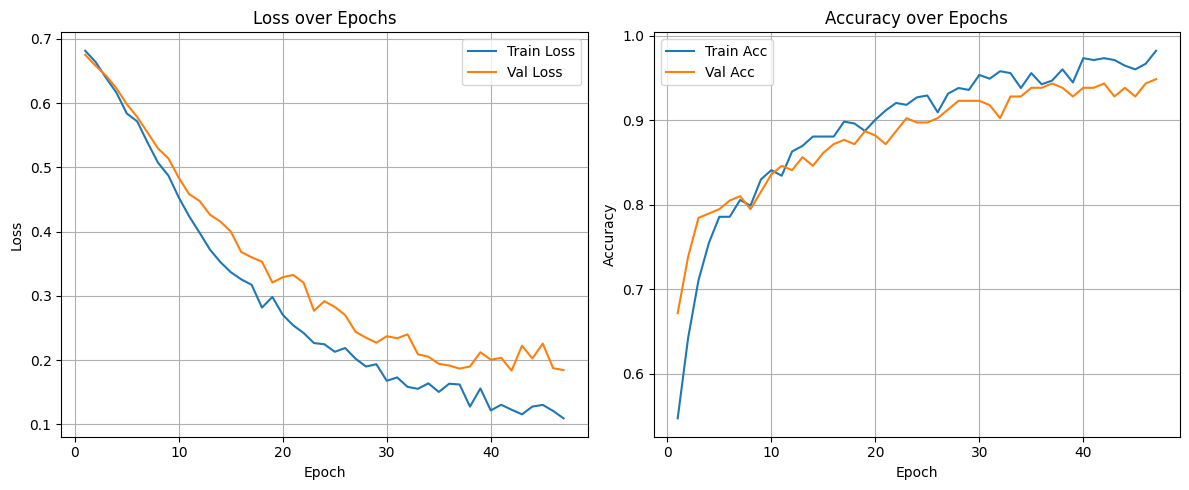

In [ ]:
plot_training_results(metrics)

# Inference (Test)

In [ ]:
def evaluate_on_test(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)

    print(f"\n🔍 Test Evaluation Metrics:")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print(f"Confusion Matrix:\n{cm}")

    return acc, precision, recall, f1, cm


In [ ]:
# Dataset & DataLoader
test_dataset = FireDataset(data_pairs=list(zip(test_images, test_labels)), transform=val_test_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

model, _ = make_mobilenetv2_model(device, dropout=0.19)
model.load_state_dict(torch.load("/content/best_model_emobilenetv2.pt", map_location=device))
model.eval()


# Inference
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels)
        y_pred.extend(preds.cpu().numpy())

# Report
print("📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=["No Fire", "Fire"]))

📊 Classification Report:
              precision    recall  f1-score   support

     No Fire       0.91      0.89      0.90        36
        Fire       0.89      0.92      0.90        36

    accuracy                           0.90        72
   macro avg       0.90      0.90      0.90        72
weighted avg       0.90      0.90      0.90        72



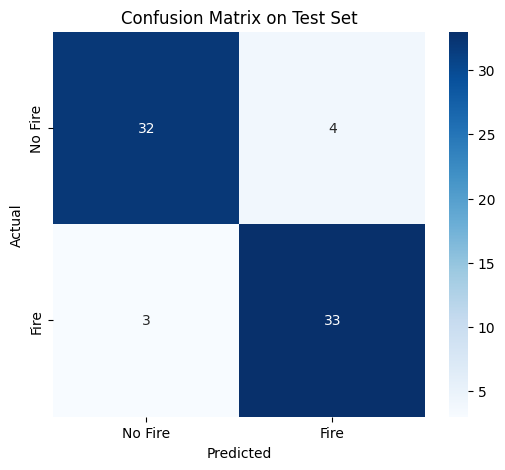

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Fire", "Fire"], yticklabels=["No Fire", "Fire"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix on Test Set")
plt.show()